<a href="https://colab.research.google.com/github/JorgeAnsotegui/TFM/blob/main/Generate_json.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
from google.colab import drive
import shutil
import zipfile
import os

# Montar Google Drive
drive.mount('/content/drive')

# Definir las rutas de los archivos y directorios
source_file = '/content/drive/MyDrive/TFM/Polipos Segmentados.zip'
destination_dir = '/content/Dataset/Polipos'

# Crear el directorio si no existe
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

# Copiar el archivo
shutil.copy(source_file, destination_dir)
print(f'Archivo copiado a: {os.path.join(destination_dir, os.path.basename(source_file))}')

# Descomprimir el archivo ZIP
zip_path = os.path.join(destination_dir, os.path.basename(source_file))
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(destination_dir)
    print(f'Archivo descomprimido en: {destination_dir}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archivo copiado a: /content/Dataset/Polipos/Polipos Segmentados.zip
Archivo descomprimido en: /content/Dataset/Polipos


In [17]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Definir las rutas de los archivos y directorios
source_dir = '/content/Dataset/Polipos/segmentación polipos 265'
destination_base_dir = '/content/Dataset/Polipos/TrainValTest'

# Crear directorios de destino si no existen
train_dir = os.path.join(destination_base_dir, 'train')
val_dir = os.path.join(destination_base_dir, 'val')
test_dir = os.path.join(destination_base_dir, 'test')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Listar todas las imágenes en el directorio fuente, excluyendo las que terminan en (1).jpg
all_images = [f for f in os.listdir(source_dir) if f.endswith('.jpg') and not f.endswith('(1).jpg')]

# Dividir las imágenes en train (60%), val (20%), y test (20%)
train_images, test_images = train_test_split(all_images, test_size=0.4, random_state=42)
val_images, test_images = train_test_split(test_images, test_size=0.5, random_state=42)

# Función para copiar imágenes a los directorios correspondientes
def copy_images(image_list, destination_dir):
    for image in image_list:
        source_file = os.path.join(source_dir, image)
        destination_file = os.path.join(destination_dir, image)
        shutil.copyfile(source_file, destination_file)

copy_images(train_images, train_dir)
copy_images(val_images, val_dir)
copy_images(test_images, test_dir)

print("División de imágenes completada.")


División de imágenes completada.


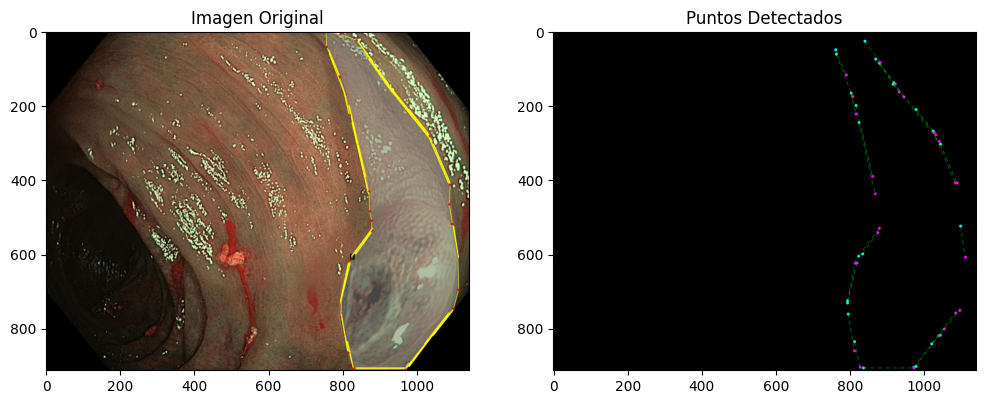

Coordenadas de los inicios de las líneas amarillas: [(919, 139), (837, 907), (817, 200), (870, 75), (825, 246), (917, 143), (1025, 269), (1044, 819), (1021, 842), (1099, 525), (979, 903), (973, 905), (1045, 304), (764, 62), (979, 211), (794, 732), (796, 762), (881, 86), (762, 50), (824, 606), (841, 27), (813, 836), (835, 600), (880, 86), (804, 167), (794, 726)]
Coordenadas de los finales de las líneas amarillas: [(1032, 279), (973, 907), (862, 391), (933, 164), (869, 438), (1041, 297), (1085, 409), (1097, 752), (1086, 759), (1112, 609), (1055, 802), (1040, 820), (1090, 409), (808, 176), (1028, 273), (820, 624), (813, 861), (923, 142), (791, 118), (880, 531), (882, 84), (828, 905), (876, 543), (946, 177), (817, 223), (815, 625)]


In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_yellow_lines(image):
    # Convertir la imagen a espacio de color HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Definir el rango de color amarillo en HSV
    lower_yellow = np.array([20, 100, 100])
    upper_yellow = np.array([30, 255, 255])

    # Crear una máscara para el color amarillo
    mask_yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)

    # Aplicar detección de bordes usando Canny
    edges = cv2.Canny(mask_yellow, 50, 150)

    # Detectar líneas usando la transformada de Hough
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=50, minLineLength=50, maxLineGap=10)

    yellow_line_starts = []
    yellow_line_ends = []
    if lines is not None:
        for line in lines:
            for x1, y1, x2, y2 in line:
                yellow_line_starts.append((x1, y1))
                yellow_line_ends.append((x2, y2))
                cv2.line(image, (x1, y1), (x2, y2), (0, 255, 255), 2)

    return yellow_line_starts, yellow_line_ends

def draw_dashed_line(img, start_point, end_point, color, thickness=1, dash_length=10):
    # Función para dibujar una línea discontinua
    x1, y1 = start_point
    x2, y2 = end_point
    dx = x2 - x1
    dy = y2 - y1
    dist = int(np.sqrt(dx**2 + dy**2))
    for i in range(0, dist, dash_length*2):
        start = (int(x1 + (dx * i) / dist), int(y1 + (dy * i) / dist))
        end = (int(x1 + (dx * (i + dash_length)) / dist), int(y1 + (dy * (i + dash_length)) / dist))
        cv2.line(img, start, end, color, thickness)

def main(image_path):
    # Cargar la imagen
    image = cv2.imread(image_path)

    # Detectar líneas amarillas
    yellow_line_starts, yellow_line_ends = detect_yellow_lines(image)

    # Crear una nueva imagen negra del mismo tamaño
    black_image = np.zeros_like(image)

    # Pintar puntos cian en los inicios de las líneas amarillas
    for start in yellow_line_starts:
        cv2.circle(black_image, start, 4, (255, 255, 0), -1)  # Color cian (BGR: 255, 255, 0)

    # Pintar puntos magenta en los finales de las líneas amarillas
    for end in yellow_line_ends:
        cv2.circle(black_image, end, 4, (255, 0, 255), -1)  # Color magenta (BGR: 255, 0, 255)

    # Pintar líneas discontinuas en verde lima entre los puntos iniciales y finales
    for start, end in zip(yellow_line_starts, yellow_line_ends):
        draw_dashed_line(black_image, start, end, (0, 255, 0), thickness=1)  # Color verde lima (BGR: 0, 255, 0)

    # Mostrar la imagen original con los resultados
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title('Imagen Original')
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # Mostrar la nueva imagen con puntos cian y magenta y líneas discontinuas verdes
    plt.subplot(1, 2, 2)
    plt.title('Puntos Detectados')
    plt.imshow(cv2.cvtColor(black_image, cv2.COLOR_BGR2RGB))
    plt.show()

    # Devolver las listas de inicios y finales de líneas
    return yellow_line_starts, yellow_line_ends

# Ruta de la imagen a procesar
image_path = '/content/Dataset/Polipos/TrainValTest/test/100H0017.jpg'

# Ejecutar el programa
yellow_line_starts, yellow_line_ends = main(image_path)
print("Coordenadas de los inicios de las líneas amarillas:", yellow_line_starts)
print("Coordenadas de los finales de las líneas amarillas:", yellow_line_ends)


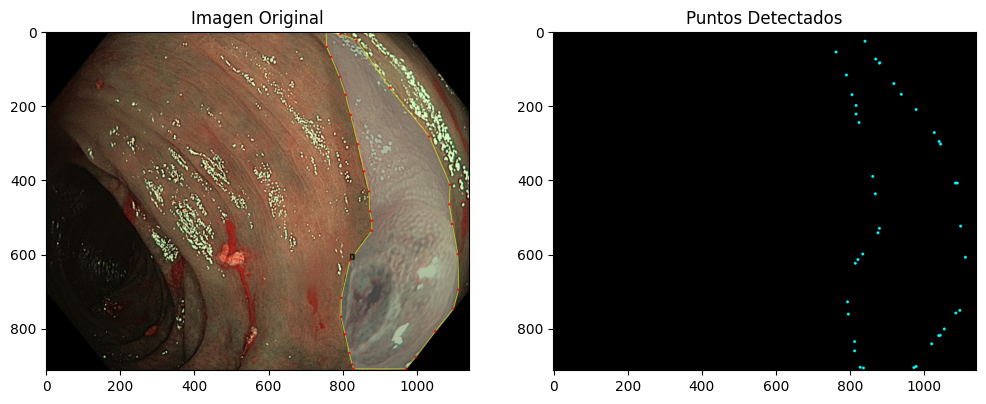

Coordenadas de los puntos amarillos agrupados: [array([763.,  56.]), array([791., 118.]), array([794., 729.]), array([796., 762.]), array([806. , 171.5]), array([813., 836.]), array([813., 861.]), array([815., 625.]), array([817., 200.]), array([817., 223.]), array([822., 615.]), array([825., 246.]), array([828., 905.]), array([835., 600.]), array([837., 907.]), array([841.,  27.]), array([862., 391.]), array([869., 438.]), array([870.,  75.]), array([876., 543.]), array([880.,  86.]), array([880., 531.]), array([881.5,  85. ]), array([919.66666667, 141.33333333]), array([939.5, 170.5]), array([973., 906.]), array([979., 211.]), array([979., 903.]), array([1021.,  842.]), array([1028.33333333,  273.66666667]), array([1040.,  820.]), array([1041.,  297.]), array([1044.,  819.]), array([1045.,  304.]), array([1055.,  802.]), array([1085.,  409.]), array([1086.,  759.]), array([1090.,  409.]), array([1097.,  752.]), array([1099.,  525.]), array([1112.,  609.])]


In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_yellow_lines(image):
    # Convertir la imagen a espacio de color HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Definir el rango de color amarillo en HSV
    lower_yellow = np.array([20, 100, 100])
    upper_yellow = np.array([30, 255, 255])

    # Crear una máscara para el color amarillo
    mask_yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)

    # Aplicar detección de bordes usando Canny
    edges = cv2.Canny(mask_yellow, 50, 150)

    # Detectar líneas usando la transformada de Hough
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=50, minLineLength=50, maxLineGap=10)

    yellow_line_points = []
    if lines is not None:
        for line in lines:
            for x1, y1, x2, y2 in line:
                yellow_line_points.append((x1, y1))
                yellow_line_points.append((x2, y2))

    return yellow_line_points

def group_nearby_points(points, threshold_distance):
    grouped_points = []
    points = sorted(points)  # Ordenar puntos para facilitar el agrupamiento

    # Agrupar puntos cercanos
    current_group = [points[0]]
    for i in range(1, len(points)):
        if np.linalg.norm(np.array(points[i]) - np.array(current_group[-1])) < threshold_distance:
            current_group.append(points[i])
        else:
            grouped_points.append(np.mean(current_group, axis=0))  # Tomar el punto medio del grupo como representante
            current_group = [points[i]]
    grouped_points.append(np.mean(current_group, axis=0))  # Agregar el último grupo

    return grouped_points

def main(image_path):
    # Cargar la imagen
    image = cv2.imread(image_path)

    # Detectar líneas amarillas
    yellow_line_points = detect_yellow_lines(image)

    # Agrupar puntos cercanos
    threshold_distance = 20  # Umbral de distancia para considerar puntos cercanos
    grouped_points = group_nearby_points(yellow_line_points, threshold_distance)

    # Crear una nueva imagen negra del mismo tamaño
    black_image = np.zeros_like(image)

    # Pintar puntos cian en los puntos detectados
    for point in grouped_points:
        cv2.circle(black_image, (int(point[0]), int(point[1])), 4, (255, 255, 0), -1)  # Color cian (BGR: 255, 255, 0)

    # Mostrar la imagen original con los resultados
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title('Imagen Original')
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # Mostrar la nueva imagen con puntos cian
    plt.subplot(1, 2, 2)
    plt.title('Puntos Detectados')
    plt.imshow(cv2.cvtColor(black_image, cv2.COLOR_BGR2RGB))
    plt.show()

    # Devolver la lista de puntos agrupados
    return grouped_points

# Ruta de la imagen a procesar
image_path = '/content/Dataset/Polipos/TrainValTest/test/100H0017.jpg'

# Ejecutar el programa
grouped_points = main(image_path)
print("Coordenadas de los puntos amarillos agrupados:", grouped_points)


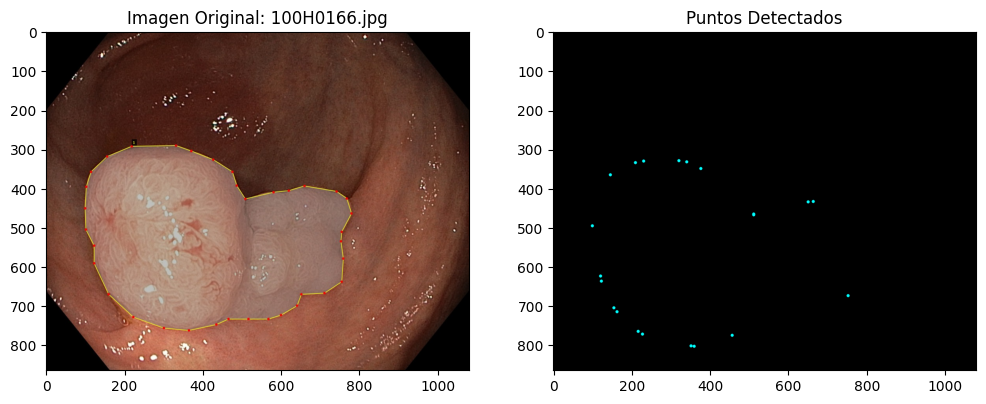

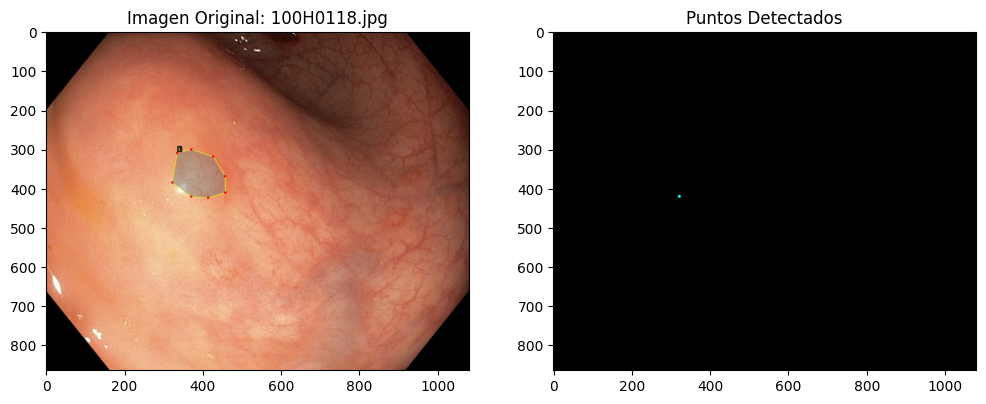

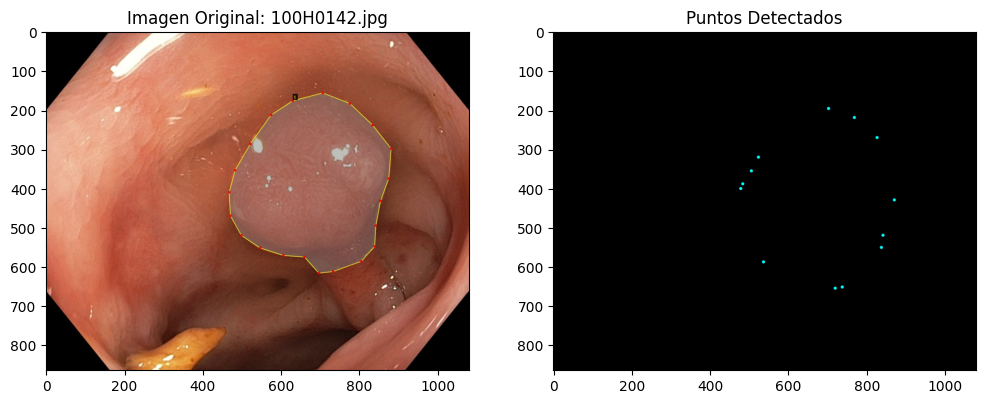

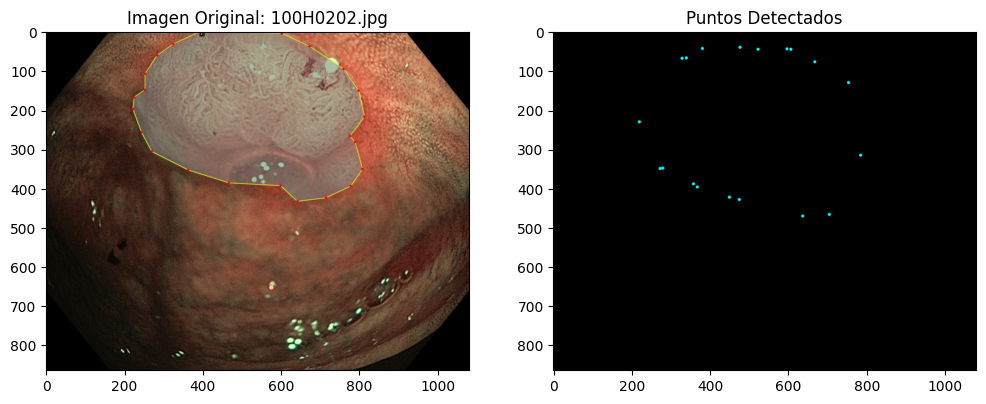

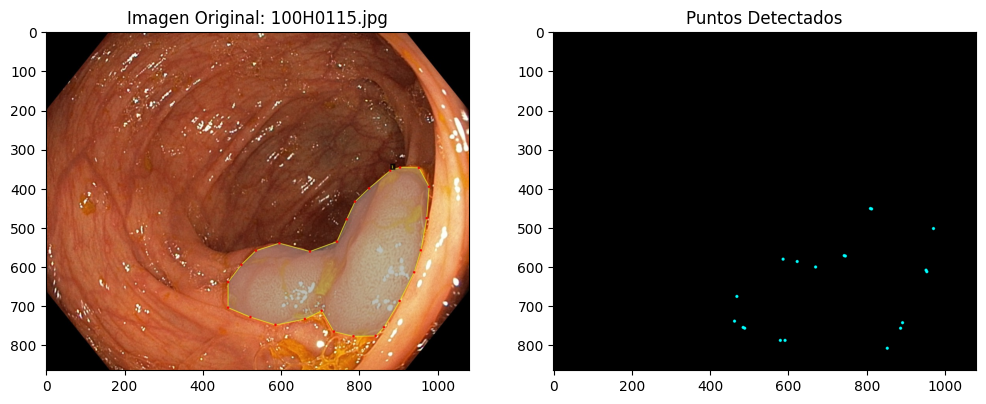

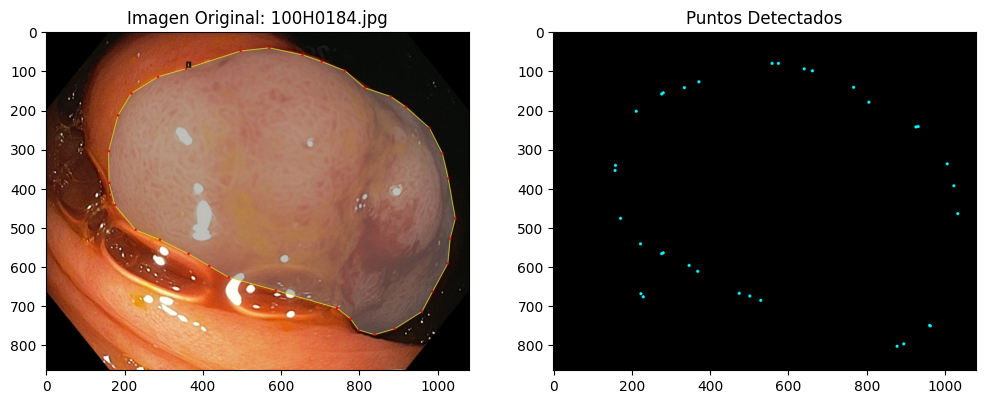

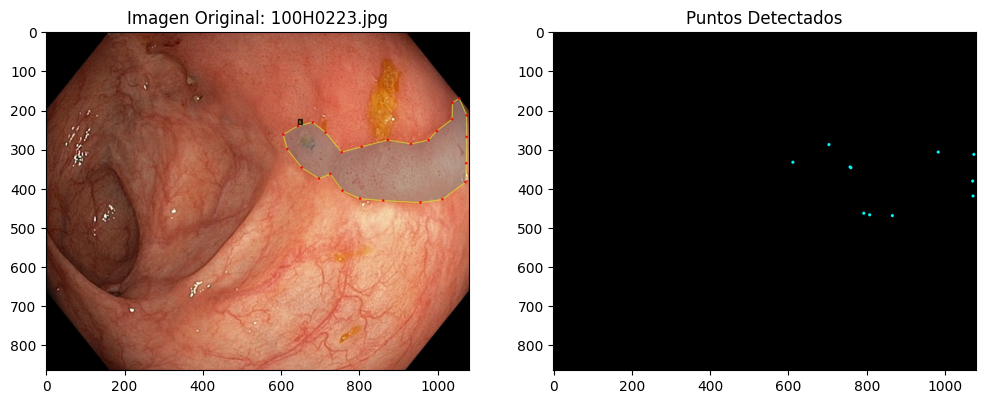

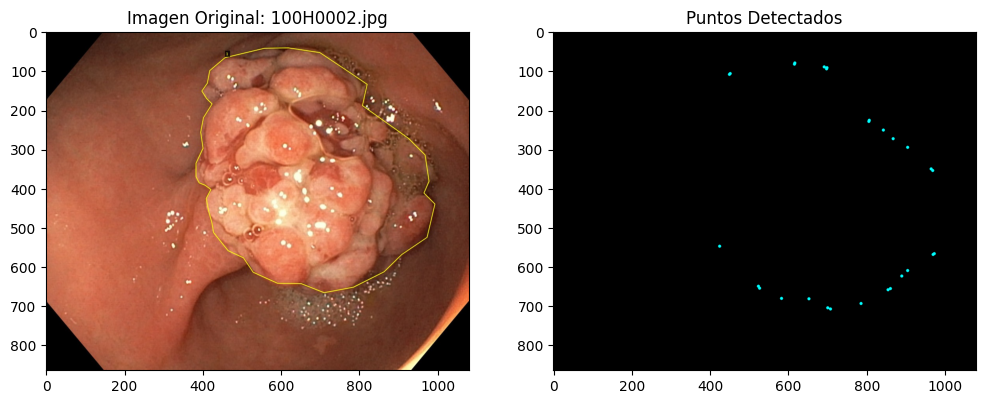

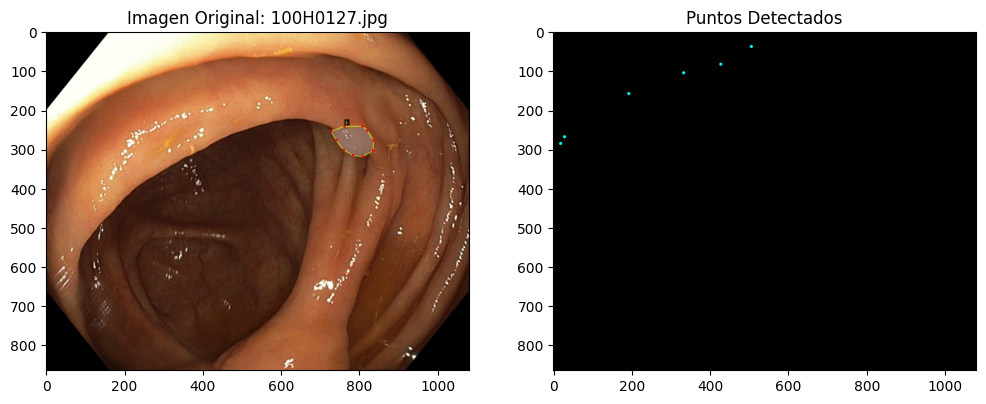

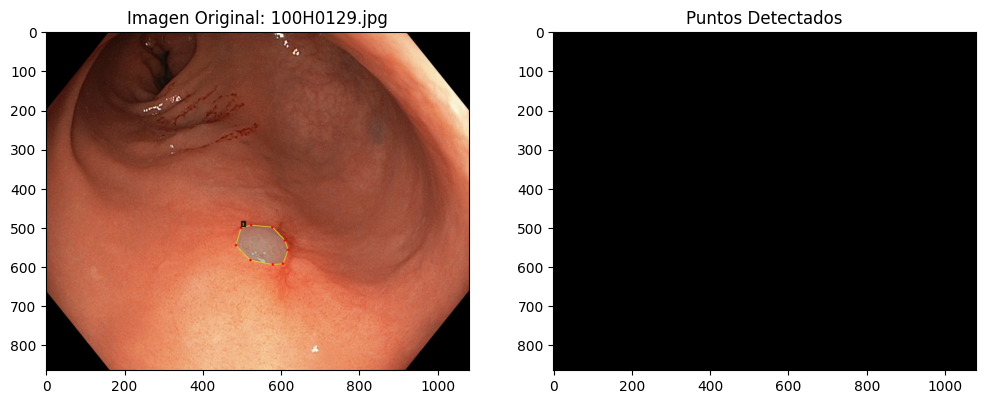

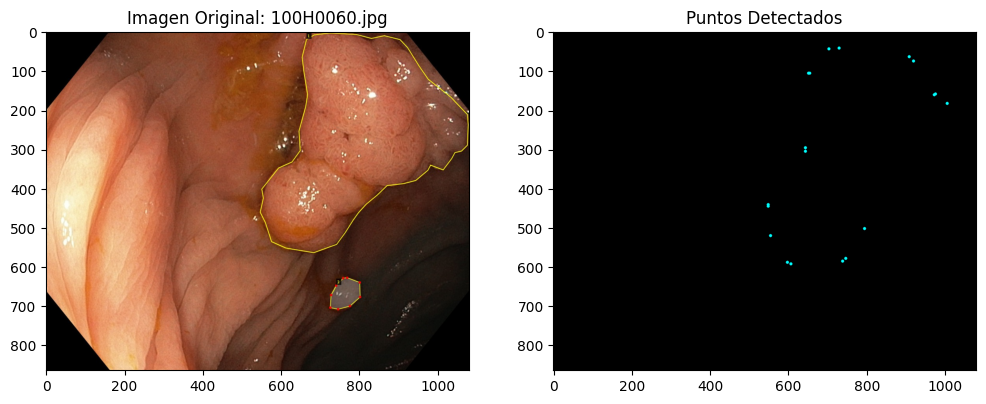

TypeError: Object of type int32 is not JSON serializable

In [26]:
import os
import cv2
import numpy as np
import json
import matplotlib.pyplot as plt

def detect_yellow_lines(image):
    # Agregar una banda negra de 20 píxeles en la parte superior de la imagen
    height, width = image.shape[:2]
    image_with_border = np.zeros((height + 20, width, 3), dtype=np.uint8)
    image_with_border[20:, :] = image

    # Convertir la imagen a espacio de color HSV
    hsv = cv2.cvtColor(image_with_border, cv2.COLOR_BGR2HSV)

    # Definir el rango de color amarillo en HSV
    lower_yellow = np.array([20, 100, 100])
    upper_yellow = np.array([30, 255, 255])

    # Crear una máscara para el color amarillo
    mask_yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)

    # Aplicar detección de bordes usando Canny
    edges = cv2.Canny(mask_yellow, 50, 150)

    # Detectar líneas usando la transformada de Hough
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=50, minLineLength=50, maxLineGap=10)

    yellow_line_starts = []
    yellow_line_ends = []
    if lines is not None:
        for line in lines:
            for x1, y1, x2, y2 in line:
                yellow_line_starts.append((x1, y1 + 20))  # Añadir 20 píxeles al eje y para compensar el borde negro
                yellow_line_ends.append((x2, y2 + 20))    # Añadir 20 píxeles al eje y para compensar el borde negro

    return yellow_line_starts, yellow_line_ends

def save_annotations(image_dir, output_json):
    annotations = {}
    for filename in os.listdir(image_dir):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(image_dir, filename)
            image = cv2.imread(image_path)
            yellow_line_starts, yellow_line_ends = detect_yellow_lines(image)
            annotations[filename] = {
                "fileref": "",
                "size": os.path.getsize(image_path),
                "filename": filename,
                "base64_img_data": "",
                "file_attributes": {},
                "regions": {
                    "0": {
                        "shape_attributes": {
                            "name": "polygon",
                            "all_points_x": [point[0] for point in yellow_line_starts],
                            "all_points_y": [point[1] for point in yellow_line_starts]
                        },
                        "region_attributes": {}
                    }
                }
            }
            # Mostrar las primeras y últimas 5 imágenes con las líneas amarillas resaltadas
            if len(annotations) <= 5 or len(annotations) >= len(os.listdir(image_dir)) - 5:
                black_image = np.zeros_like(image)
                for start in yellow_line_starts:
                    cv2.circle(black_image, start, 4, (255, 255, 0), -1)  # Color cian (BGR: 255, 255, 0)
                plt.figure(figsize=(12, 6))
                plt.subplot(1, 2, 1)
                plt.title('Imagen Original: ' + filename)
                plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                plt.subplot(1, 2, 2)
                plt.title('Puntos Detectados')
                plt.imshow(cv2.cvtColor(black_image, cv2.COLOR_BGR2RGB))
                plt.show()
    with open(output_json, 'w') as f:
        json.dump(annotations, f, indent=4)

# Directorio de las imágenes de prueba
image_dir = '/content/Dataset/Polipos/TrainValTest/test'
# Ruta para guardar el archivo JSON
output_json = '/content/annotations.json'

# Generar y guardar las anotaciones
save_annotations(image_dir, output_json)

print("Archivo JSON generado con las anotaciones guardado en:", output_json)


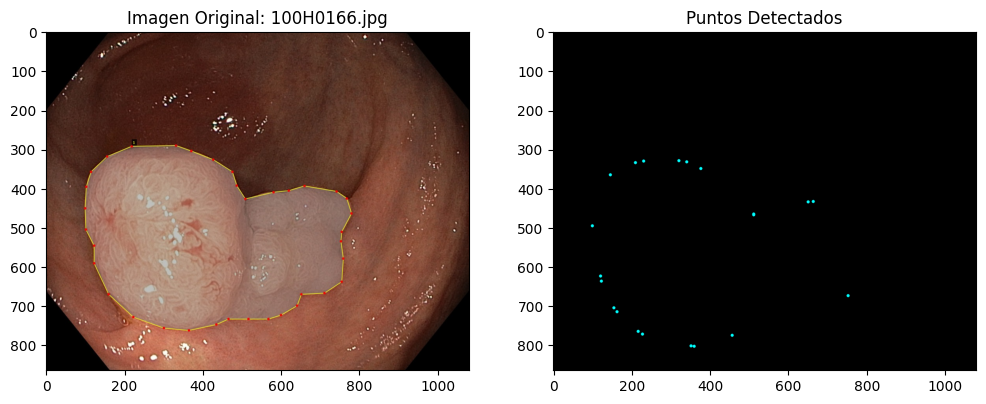

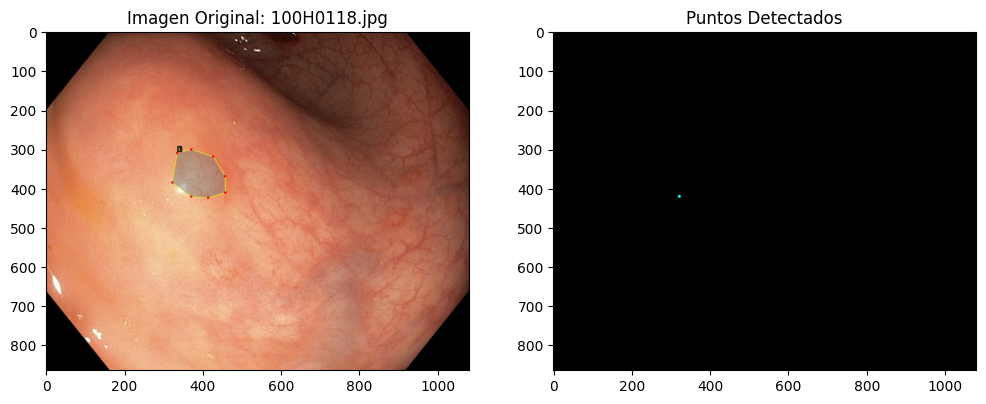

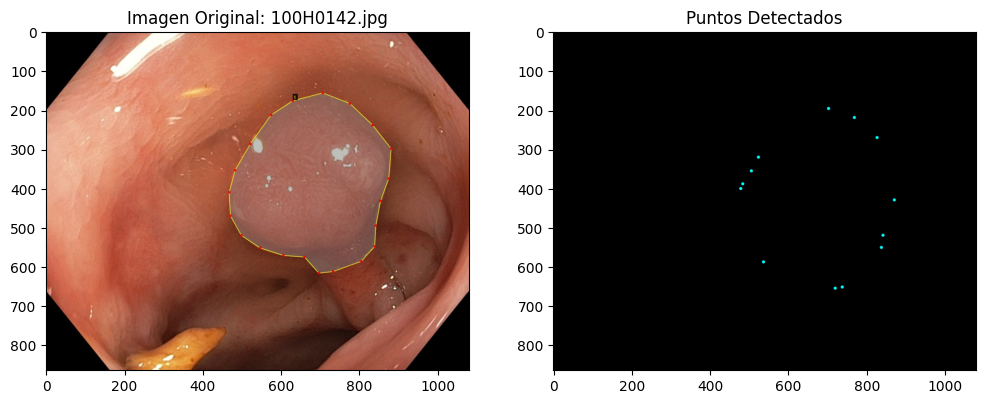

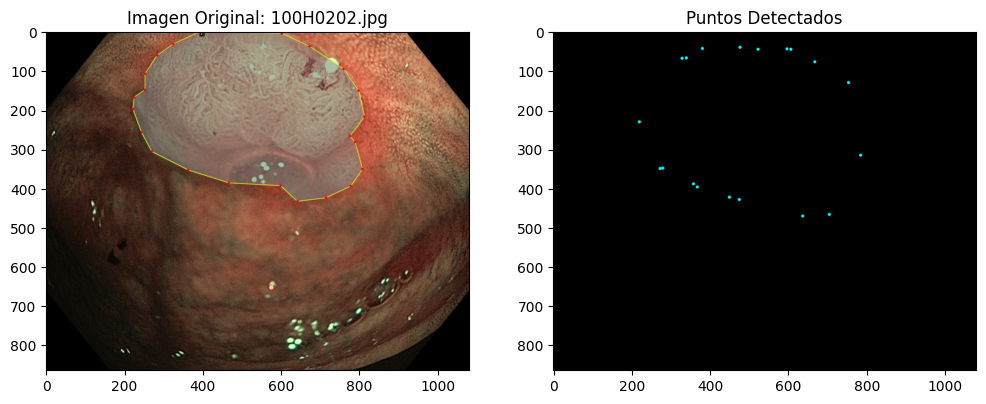

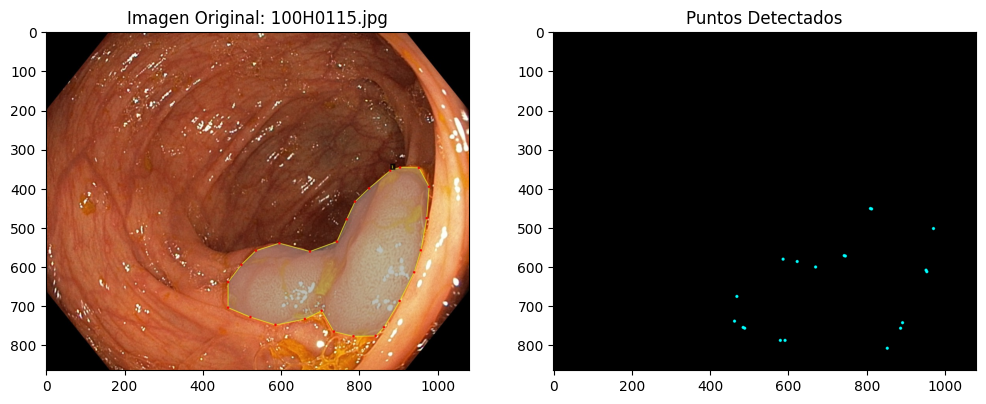

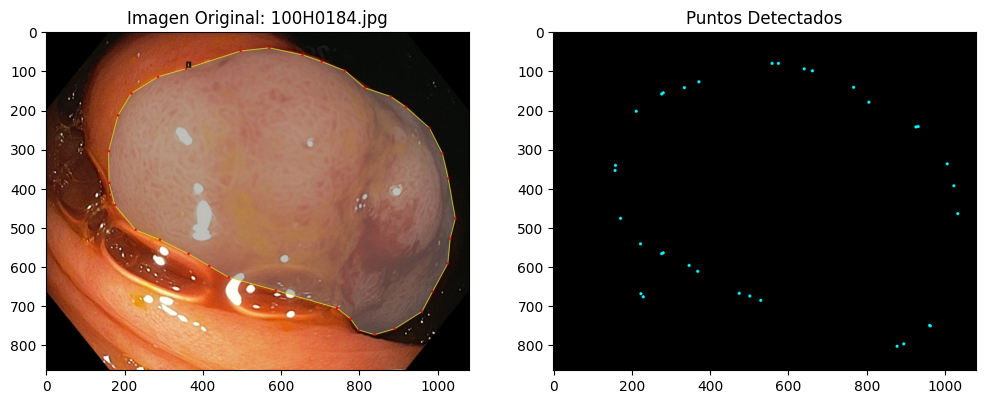

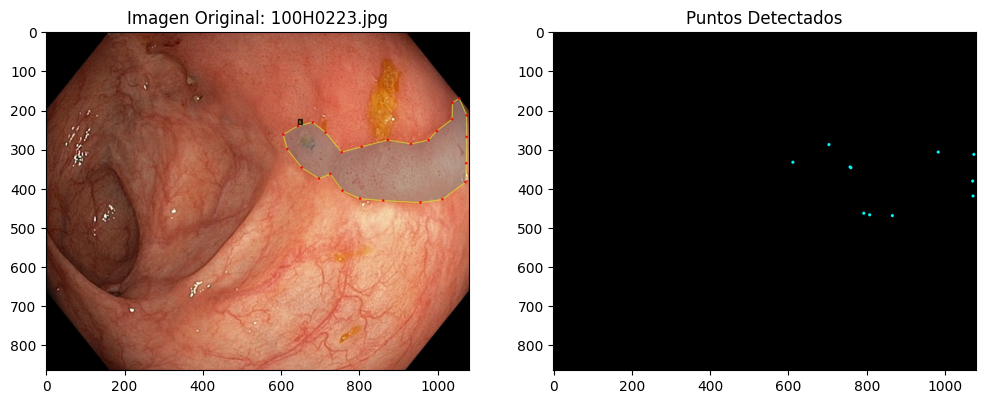

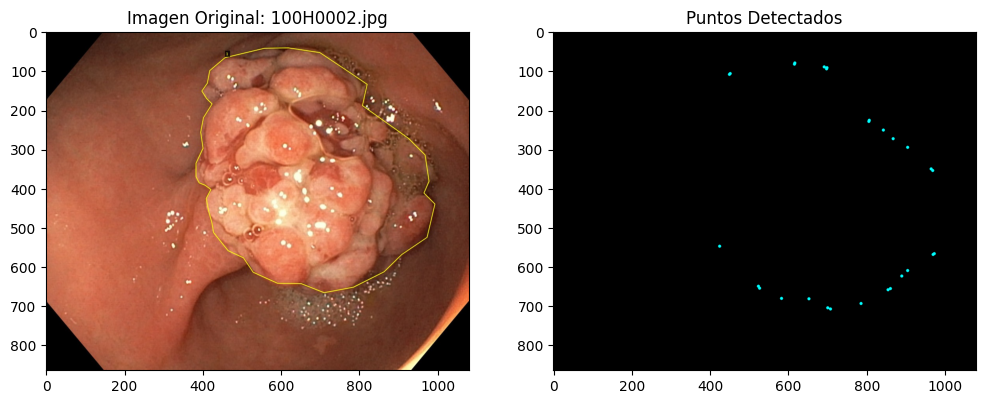

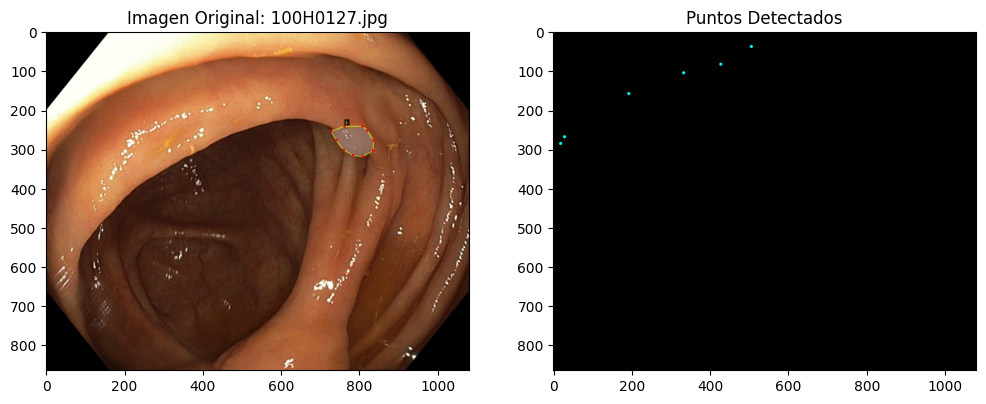

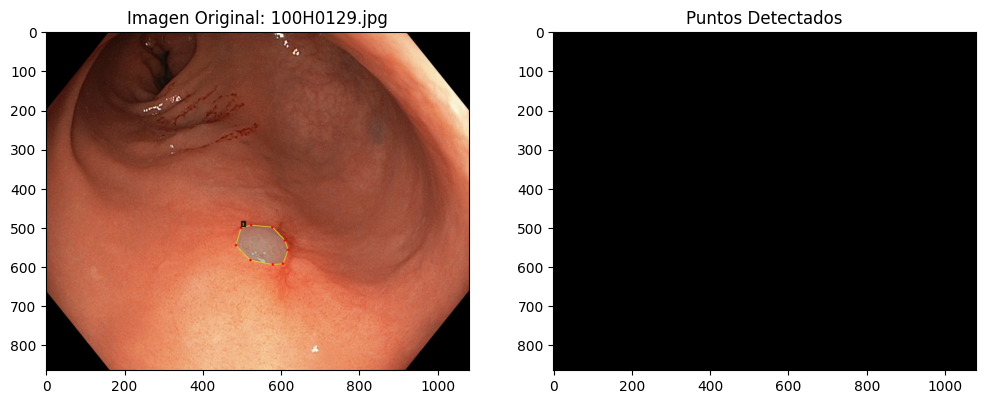

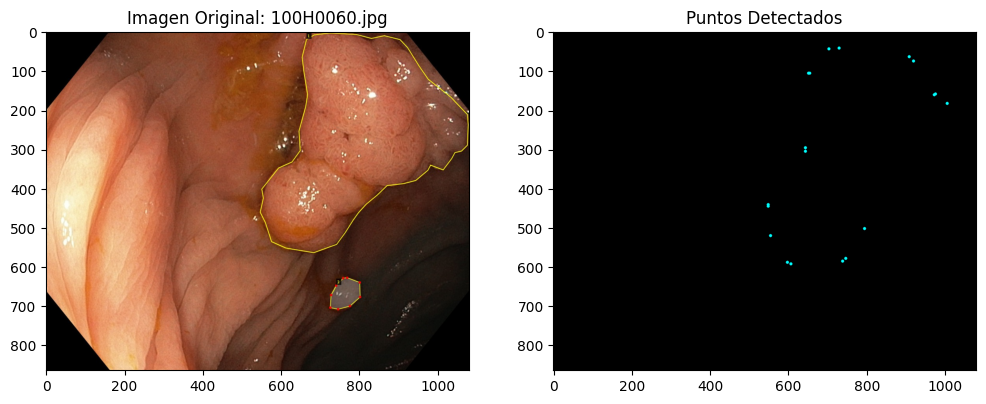

TypeError: Object of type int32 is not JSON serializable

In [27]:
import os
import cv2
import numpy as np
import json
import matplotlib.pyplot as plt

def detect_yellow_lines(image):
    # Agregar una banda negra de 20 píxeles en la parte superior de la imagen
    height, width = image.shape[:2]
    image_with_border = np.zeros((height + 20, width, 3), dtype=np.uint8)
    image_with_border[20:, :] = image

    # Convertir la imagen a espacio de color HSV
    hsv = cv2.cvtColor(image_with_border, cv2.COLOR_BGR2HSV)

    # Definir el rango de color amarillo en HSV
    lower_yellow = np.array([20, 100, 100])
    upper_yellow = np.array([30, 255, 255])

    # Crear una máscara para el color amarillo
    mask_yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)

    # Aplicar detección de bordes usando Canny
    edges = cv2.Canny(mask_yellow, 50, 150)

    # Detectar líneas usando la transformada de Hough
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=50, minLineLength=50, maxLineGap=10)

    yellow_line_starts = []
    yellow_line_ends = []
    if lines is not None:
        for line in lines:
            for x1, y1, x2, y2 in line:
                yellow_line_starts.append((x1, y1 + 20))  # Añadir 20 píxeles al eje y para compensar el borde negro
                yellow_line_ends.append((x2, y2 + 20))    # Añadir 20 píxeles al eje y para compensar el borde negro

    return yellow_line_starts, yellow_line_ends

def save_annotations(image_dir, output_json):
    annotations = {}
    for filename in os.listdir(image_dir):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(image_dir, filename)
            image = cv2.imread(image_path)
            yellow_line_starts, yellow_line_ends = detect_yellow_lines(image)
            # Convertir las coordenadas de los puntos a listas
            yellow_line_starts = [list(point) for point in yellow_line_starts]
            yellow_line_ends = [list(point) for point in yellow_line_ends]
            annotations[filename] = {
                "fileref": "",
                "size": os.path.getsize(image_path),
                "filename": filename,
                "base64_img_data": "",
                "file_attributes": {},
                "regions": {
                    "0": {
                        "shape_attributes": {
                            "name": "polygon",
                            "all_points_x": [point[0] for point in yellow_line_starts],
                            "all_points_y": [point[1] for point in yellow_line_starts]
                        },
                        "region_attributes": {}
                    }
                }
            }
            # Mostrar las primeras y últimas 5 imágenes con las líneas amarillas resaltadas
            if len(annotations) <= 5 or len(annotations) >= len(os.listdir(image_dir)) - 5:
                black_image = np.zeros_like(image)
                for start in yellow_line_starts:
                    cv2.circle(black_image, tuple(start), 4, (255, 255, 0), -1)  # Color cian (BGR: 255, 255, 0)
                plt.figure(figsize=(12, 6))
                plt.subplot(1, 2, 1)
                plt.title('Imagen Original: ' + filename)
                plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                plt.subplot(1, 2, 2)
                plt.title('Puntos Detectados')
                plt.imshow(cv2.cvtColor(black_image, cv2.COLOR_BGR2RGB))
                plt.show()
    with open(output_json, 'w') as f:
        json.dump(annotations, f, indent=4)

# Directorio de las imágenes de prueba
image_dir = '/content/Dataset/Polipos/TrainValTest/test'
# Ruta para guardar el archivo JSON
output_json = '/content/annotations.json'

# Generar y guardar las anotaciones
save_annotations(image_dir, output_json)

print("Archivo JSON generado con las anotaciones guardado en:", output_json)
